200
(200, 200)


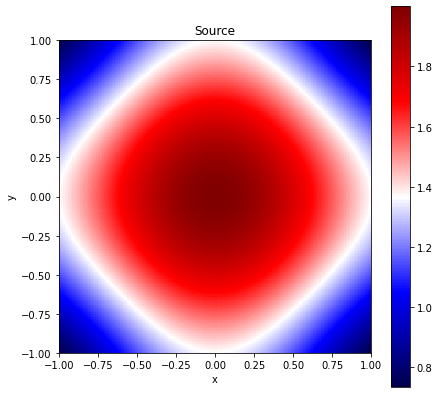

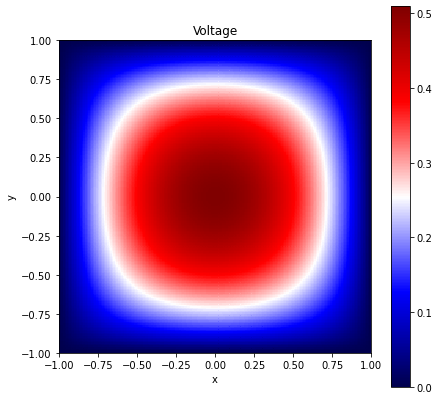

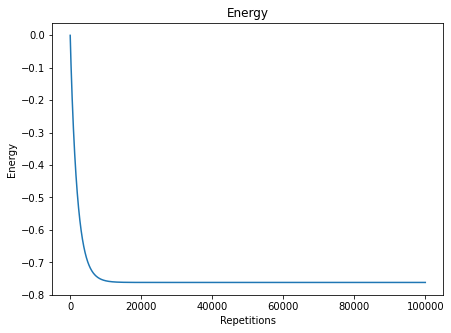

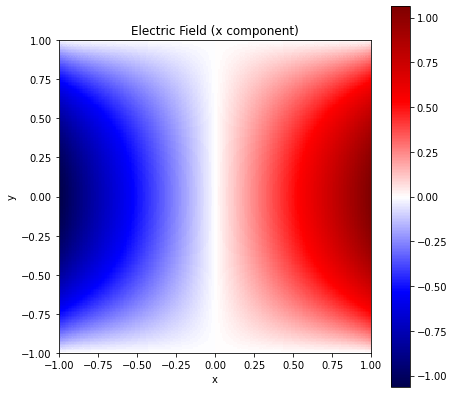

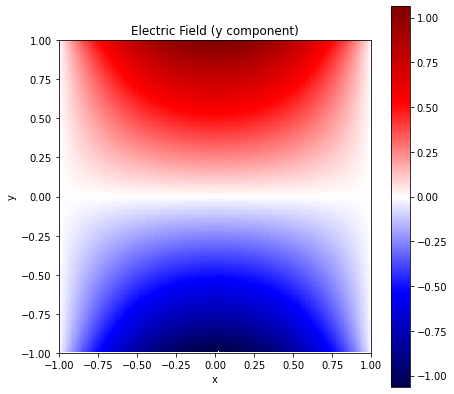

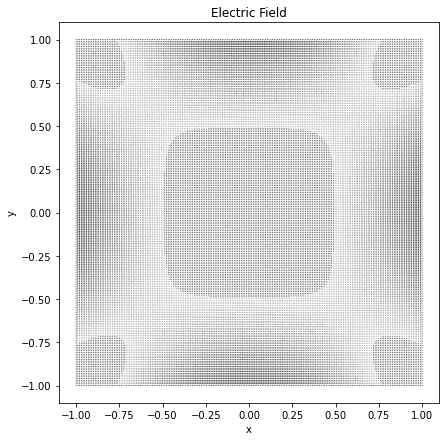

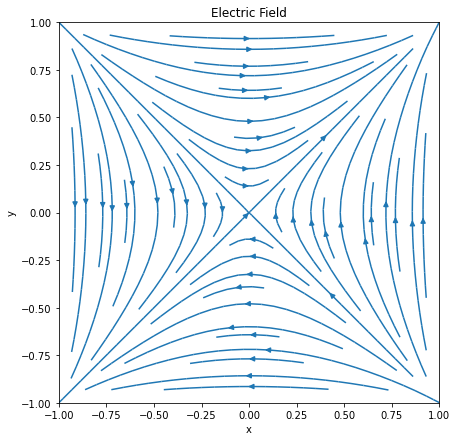

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from numba import jit

#number of approximations
reps=100000
#resolutionx resolutiony number of points in each axis
step=0.01
boundaries=np.array([[-1,1],[-1,1]]) #(x1,x2) , (y1,y2) 

#necessary Initializations
resolutionx,resolutiony=int((boundaries[0,1]-boundaries[0,0])/step),int((boundaries[1,1]-boundaries[1,0])/step)
x=np.linspace(boundaries[0,0],boundaries[0,1],resolutionx)
y=np.linspace(boundaries[1,0],boundaries[1,1],resolutiony)
print(resolutionx)
X,Y=np.meshgrid(x,y,indexing="ij")
voltage=np.zeros((resolutionx,resolutiony))
electricField=np.zeros((resolutionx,resolutiony,2))
source=np.zeros((resolutionx,resolutiony))
for i in range(resolutionx):
  for j in range(resolutiony):
                 source[i,j]=np.exp(-x[i]**2)+np.exp(-y[j]**2)

print(voltage.shape)
#boundary conditions
#x sides 
voltage[:,0]=0
voltage[:,resolutiony-1]=0
#y sides
voltage[0,:]=0
voltage[resolutionx-1,:]=0

#There is no charge in this example
#source=np.exp(-Y**2-X**2)

#choosing colormap
cmap=cm.get_cmap("seismic")

#plotting the Source
plt.figure(figsize=[7,7])
plt.pcolormesh(X, Y, source, cmap=cmap)
plt.title("Source")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.gca().set_aspect('equal')     
plt.show()

def plotVoltage(X, Y, voltage):
  fig, ax=plt.subplots(figsize=(7,7))
  im=ax.pcolormesh(X, Y, voltage, cmap=cm.get_cmap("seismic"))
  ax.set_title("Voltage")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_aspect("equal")
  fig.colorbar(im)
  fig.savefig("2-D Poisson Conv.png")
  return

#Approximating voltage
@jit(nopython=True)
def calculate(reps, resolutionx, resolutiony, step, source, voltage, X, Y):
  energy=np.zeros(reps)
  for n in range(reps):
      sum1=sum2=0
      for i in range(1,resolutionx-1):
          for j in range(1,resolutiony-1):
              voltage[i,j]=(voltage[i+1,j]+voltage[i-1,j]+voltage[i,j+1]+voltage[i,j-1]+np.power(step,2)*source[i,j])/4
      #calculating energy
      for i in range(1,resolutionx):
              for j in range(1,resolutiony):
                  sum1+=np.power((voltage[i,j]-voltage[i-1,j]),2)+np.power((voltage[i,j]-voltage[i,j-1]),2)
                  if i!=resolutionx or j!=resolutiony:    
                      sum2+=source[i,j]*voltage[i,j]
      energy[n]=0.5*sum1-np.power(step,2)*sum2

  return voltage,energy

voltage, energy=calculate(reps, resolutionx, resolutiony, step, source, voltage, X, Y)
plotVoltage(X, Y, voltage)

np.save("convVoltage.npy", voltage)
np.save("y.npy", y)
np.save("x.npy", x)

#Plotting Energy
plt.figure(figsize=[7,5])
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Repetitions")
plt.ylabel("Energy")
plt.show()

#computing electric field
for i in range(1,resolutionx-1):
    for j in range(1,resolutiony-1):
        electricField[i,j,0]=-0.5*(voltage[i+1,j]-voltage[i-1,j])/step
        electricField[i,j,1]=-0.5*(voltage[i,j+1]-voltage[i,j-1])/step

plt.figure(figsize=[7,7])
plt.pcolormesh(X,Y,electricField[:,:,0],cmap=cmap)
plt.title("Electric Field (x component)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.gca().set_aspect('equal', 'box')     
plt.show()

plt.figure(figsize=[7,7])
plt.pcolormesh(X,Y,electricField[:,:,1],cmap=cmap)
plt.title("Electric Field (y component)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.gca().set_aspect('equal', 'box')     
plt.show()

#plotting electric field (quiver) (ONLY FOR RECTANGULAR GRIDS)
plt.figure(figsize=[7,7])
plt.quiver(x, y, electricField[:,:,0], electricField[:,:,1])
plt.title("Electric Field")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', 'box')
plt.show()

#plotting electric field (streamplot) (ONLY FOR RECTANGULAR GRIDS)
plt.figure(figsize=[7,7])
plt.streamplot(x,y,electricField[:,:,0],electricField[:,:,1])
plt.title("Electric Field")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', 'box')
plt.show()